<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/XGB/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Config:
    name = "XGB/Baseline"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None

In [2]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [3]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    # ! pip install lightgbm==3.3.1
    # ! pip install --quiet iterative-stratification
    # ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "amex-default-prediction.zip")):
        # load dataset
        # ! kaggle competitions download -c amex-default-prediction -p $INPUT 
else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = "../input/amex-default-prediction"
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)


This environment is Google Colab


In [4]:
with open(os.path.join(INPUT, 'data_types.json'), "r") as rf:
    dtypes = json.load(rf)
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet') if COLAB else 'train.parquet')
train = train.astype(dtypes)
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv') if COLAB else 'train_labels.csv', dtype={'customer_ID': 'str', 'target': 'int8'})
# train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet') if COLAB else 'train_small.parquet')
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet') if COLAB else 'test.parquet')
test = test.astype(dtypes)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: category(2), datetime64[ns](1), float16(185), int8(1), object(1)
memory usage: 2.0+ GB


In [6]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827


## Evaluation merics

In [7]:
from xgboost import DMatrix
from typing import Tuple
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def xgb_amex_metric(predt: np.ndarray, dtrain: DMatrix) -> Tuple[str, float]:
    """The competition metric with xgboost's calling convention"""
    y_true = dtrain.get_label()
    return 'AmexMetric', amex_metric(pd.DataFrame({'target': y_true}), pd.Series(predt, name='prediction'))

## Preprocess

In [8]:
train = train.groupby('customer_ID')\
  .tail(1).set_index('customer_ID', drop=True)\
  .sort_index()\
  .merge(target.set_index('customer_ID', drop=True), left_index=True, right_index=True)
test =  test.groupby('customer_ID')\
  .tail(1).set_index('customer_ID', drop=True)\
  .sort_index()

In [9]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(train, test):
  categorical = ['D_63', 'D_64']
  for col in categorical:
    encoder = LabelEncoder()
    encoder.fit(train[col])
    train[col] = encoder.transform(train[col])
    test[col] = encoder.transform(test[col])
  
  return train,  test

train, test = encode_categorical(train, test)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 190 entries, S_2 to target
dtypes: datetime64[ns](1), float16(185), int64(2), int8(2)
memory usage: 176.8+ MB


## Select features to use

In [11]:
features = []
unuse = ['customer_ID', 'S_2', 'target']

features = [col for col in train.columns if col not in unuse]

## Training

In [12]:
def plot_metric(result):
  train_metric = result['validation_0']['AmexMetric']
  plt.plot(train_metric, label='amex metric')
  eval_metric = result['validation_1']['AmexMetric']
  plt.plot(eval_metric, label='amex metric')
  plt.grid()
  plt.legend()
  plt.xlabel('rounds')
  plt.ylabel('amex metric')
  plt.show()

In [13]:
from xgboost import XGBClassifier
from xgboost.callback import early_stop
from sklearn.model_selection import StratifiedKFold

def fit_xgb(X, y, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = XGBClassifier(**params,
                           booster='gbtree',
                           objective='binary:logistic',
                           n_estimators=10000,
                           random_state=Config.seed,
                          #  tree_method='gpu_hist',
                           n_jobs=-1,
                           verbose=0)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=xgb_amex_metric,
              callbacks=[early_stop(10, maximize=True)],
              verbose=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- plot -------------------
    plot_metric(model.evals_result_)

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/xgb_fold{fold}.pkl'
    model.save_model(file)
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_xgb(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
Multiple eval metrics have been passed: 'validation_1-AmexMetric' will be used for early stopping.

Will train until validation_1-AmexMetric hasn't improved in 10 rounds.
[0]	validation_0-AmexMetric:0.643883	validation_1-AmexMetric:0.6411
[50]	validation_0-AmexMetric:0.696499	validation_1-AmexMetric:0.691916
[100]	validation_0-AmexMetric:0.707518	validation_1-AmexMetric:0.702753
[150]	validation_0-AmexMetric:0.717	validation_1-AmexMetric:0.712411
[200]	validation_0-AmexMetric:0.727521	validation_1-AmexMetric:0.723159
[250]	validation_0-AmexMetric:0.735826	validation_1-AmexMetric:0.730833
[300]	validation_0-AmexMetric:0.74156	validation_1-AmexMetric:0.736388
[350]	validation_0-AmexMetric:0.747327	validation_1-AmexMetric:0.741344
[400]	validation_0-AmexMetric:0.751539	validation_1-AmexMetric:0.745088
[450]	validation_0-AmexMetric:0.755155	validation_1-AmexMetric:0.749539
[500]	vali

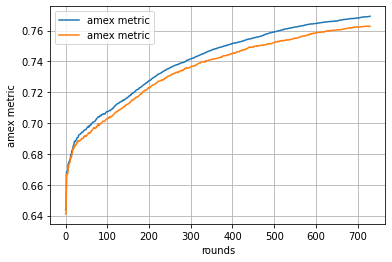

fold0 amex meric: 0.7627649376795158

-------------------------------------------------- fold1 --------------------------------------------------
Multiple eval metrics have been passed: 'validation_1-AmexMetric' will be used for early stopping.

Will train until validation_1-AmexMetric hasn't improved in 10 rounds.
[0]	validation_0-AmexMetric:0.644875	validation_1-AmexMetric:0.64256
[50]	validation_0-AmexMetric:0.698593	validation_1-AmexMetric:0.695436
[100]	validation_0-AmexMetric:0.707253	validation_1-AmexMetric:0.703891
[150]	validation_0-AmexMetric:0.71661	validation_1-AmexMetric:0.713669
[200]	validation_0-AmexMetric:0.727294	validation_1-AmexMetric:0.723564
[250]	validation_0-AmexMetric:0.73495	validation_1-AmexMetric:0.731699
[300]	validation_0-AmexMetric:0.741095	validation_1-AmexMetric:0.73704
[350]	validation_0-AmexMetric:0.746634	validation_1-AmexMetric:0.741823
[400]	validation_0-AmexMetric:0.750499	validation_1-AmexMetric:0.746467
Stopping. Best iteration:
[404]	validation

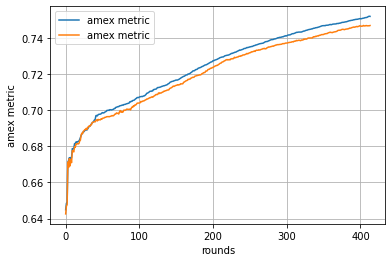

fold1 amex meric: 0.7466711350928243

-------------------------------------------------- fold2 --------------------------------------------------
Multiple eval metrics have been passed: 'validation_1-AmexMetric' will be used for early stopping.

Will train until validation_1-AmexMetric hasn't improved in 10 rounds.
[0]	validation_0-AmexMetric:0.643628	validation_1-AmexMetric:0.642052
[50]	validation_0-AmexMetric:0.697147	validation_1-AmexMetric:0.695461
[100]	validation_0-AmexMetric:0.706491	validation_1-AmexMetric:0.706718
[150]	validation_0-AmexMetric:0.716095	validation_1-AmexMetric:0.716678
[200]	validation_0-AmexMetric:0.726275	validation_1-AmexMetric:0.72628
[250]	validation_0-AmexMetric:0.734621	validation_1-AmexMetric:0.7336
[300]	validation_0-AmexMetric:0.74036	validation_1-AmexMetric:0.737685
[350]	validation_0-AmexMetric:0.745656	validation_1-AmexMetric:0.743632
[400]	validation_0-AmexMetric:0.750369	validation_1-AmexMetric:0.747708
[450]	validation_0-AmexMetric:0.753931	val

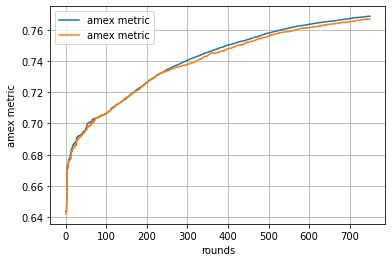

fold2 amex meric: 0.7668863402859513

-------------------------------------------------- fold3 --------------------------------------------------
Multiple eval metrics have been passed: 'validation_1-AmexMetric' will be used for early stopping.

Will train until validation_1-AmexMetric hasn't improved in 10 rounds.
[0]	validation_0-AmexMetric:0.639377	validation_1-AmexMetric:0.642723
[50]	validation_0-AmexMetric:0.697422	validation_1-AmexMetric:0.700591
[100]	validation_0-AmexMetric:0.707251	validation_1-AmexMetric:0.709948
[150]	validation_0-AmexMetric:0.717369	validation_1-AmexMetric:0.719859
[200]	validation_0-AmexMetric:0.727084	validation_1-AmexMetric:0.729421
[250]	validation_0-AmexMetric:0.734508	validation_1-AmexMetric:0.736233
[300]	validation_0-AmexMetric:0.740685	validation_1-AmexMetric:0.742297
[350]	validation_0-AmexMetric:0.745793	validation_1-AmexMetric:0.74695
Stopping. Best iteration:
[357]	validation_0-AmexMetric:0.746035	validation_1-AmexMetric:0.747772



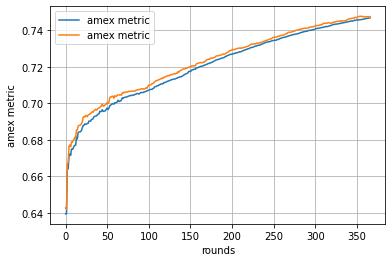

fold3 amex meric: 0.7475470967745288

-------------------------------------------------- fold4 --------------------------------------------------
Multiple eval metrics have been passed: 'validation_1-AmexMetric' will be used for early stopping.

Will train until validation_1-AmexMetric hasn't improved in 10 rounds.
[0]	validation_0-AmexMetric:0.647201	validation_1-AmexMetric:0.646435
[50]	validation_0-AmexMetric:0.697858	validation_1-AmexMetric:0.695471
[100]	validation_0-AmexMetric:0.707067	validation_1-AmexMetric:0.705633
[150]	validation_0-AmexMetric:0.717353	validation_1-AmexMetric:0.714052
[200]	validation_0-AmexMetric:0.72708	validation_1-AmexMetric:0.725774
[250]	validation_0-AmexMetric:0.734445	validation_1-AmexMetric:0.732983
[300]	validation_0-AmexMetric:0.740206	validation_1-AmexMetric:0.739489
[350]	validation_0-AmexMetric:0.745432	validation_1-AmexMetric:0.743961
[400]	validation_0-AmexMetric:0.750046	validation_1-AmexMetric:0.748583
[450]	validation_0-AmexMetric:0.754242	

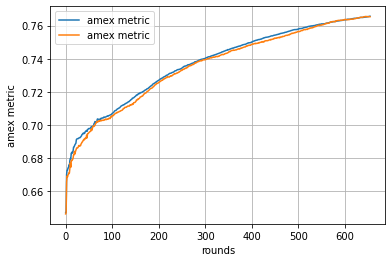

fold4 amex meric: 0.7653050148481931

OOF Score: 0.75783


In [14]:
xgb_params = {"learning_rate": 0.01,
              'disable_default_eval_metric': 1}

models = fit_xgb(train[features], train[Config.target], params=xgb_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_xgb(models, test[features])

## Plot importances

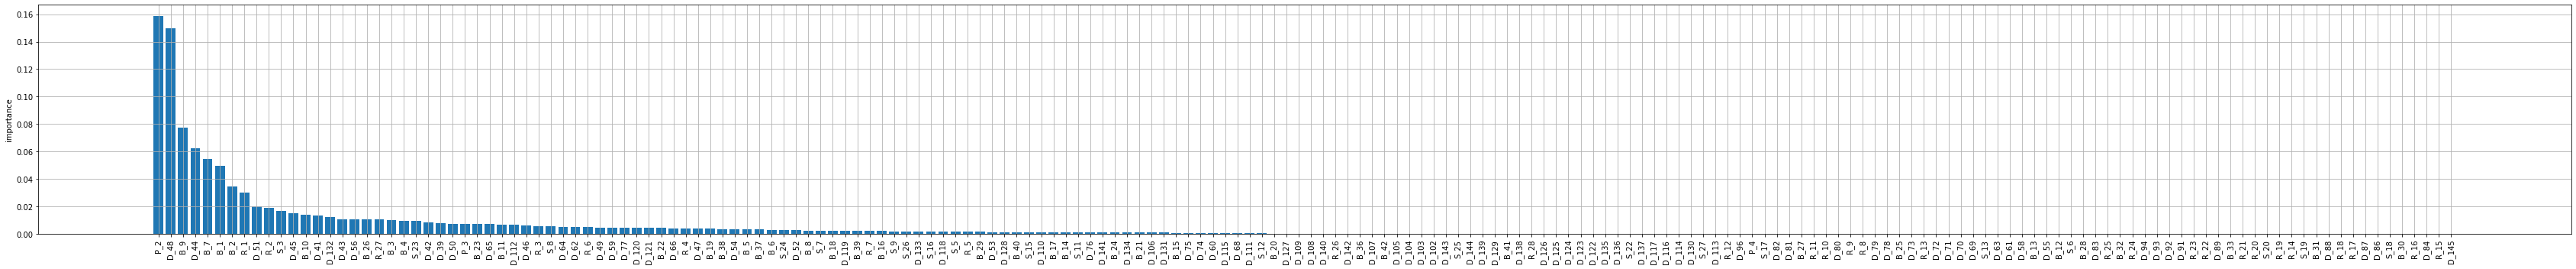

In [15]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [16]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [17]:
! kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/workspace/kaggle-amex/Submission/submission.csv -m "XGBoost Baseline"

100% 67.2M/67.2M [00:01<00:00, 44.4MB/s]
Successfully submitted to American Express - Default Prediction